Using TensorFlow backend.


Found 1093 images belonging to 2 classes.
Found 1096 images belonging to 2 classes.
Found 1096 images belonging to 2 classes.


2022-03-31 09:48:10.301903: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 09:48:10.304273: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/3
36/36 [==============================] - 2088s 58s/step - loss: 6.5665 - accuracy: 0.5569 - val_loss: 5.1253 - val_accuracy: 0.6657
Epoch 2/3
36/36 [==============================] - 1725s 48s/step - loss: 6.7453 - accuracy: 0.5616 - val_loss: 5.1253 - val_accuracy: 0.6657
Epoch 3/3
36/36 [==============================] - 1819s 51s/step - loss: 6.8447 - accuracy: 0.5550 - val_loss: 5.1253 - val_accuracy: 0.6657
Processing time [min]: 93.87351696888605
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-03-31 11:22:31.821612: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../500hPaGeopotential/binary_classification_fast202203311122_cnn_model/assets


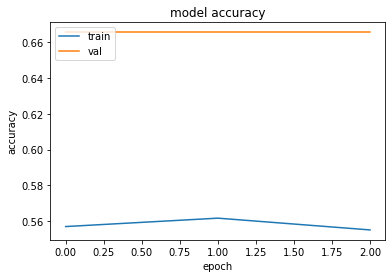

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 19 14:05:38 2022

@author: fabia
"""

###############################################################################
# Library Imports

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
import time
import pandas as pd
import os
import shutil
import datetime as dt


###############################################################################
# User Parameters

do_training = True # [CAN BE CHANGED]
do_visualization = True # [CAN BE CHANGED]

# if new classification type should be done
distribute_pictures_to_classification_folders = False
 

# data selection
start_year = 2005
train_years = 3
validation_years =3 # could be lower and train years increased
test_years = 3


# orignal picture size
original_width = 704 #pixel
original_height = 513 #pixel


# define constants
# for binary classification
basepath= "../500hPaGeopotential/binary_classification_fast"  # [TO BE ADPATED ON YOUR LOCAL MACHINE]
# for binary classification grayscale
#basepath = "D:\\DeepLearning\\500hPaGeopotential\\binary_classification_grayscale\\" # [TO BE ADPATED ON YOUR LOCAL MACHINE]


# for categorical classification [NOT YET IMPLEMENTED]
#basepath = "D:\\DeepLearning\\500hPaGeopotential\\categorical_classification\\"
# for categorical classification with forecast (D+1) [NOT YET IMPLEMENTED]
#basepath = "D:\\DeepLearning\\500hPaGeopotential\\categorical_classification_forecast\\""


# path to orignal map data
datapath = "../500hPaGeopotential/original_data" # [TO BE ADPATED ON YOUR LOCAL MACHINE]


# derived paths
trainpath = basepath + "/train"
testpath = basepath + "/test"
validationpath = basepath + "/validation"

# label file name
csvfile = '/labels.csv'

# model parameters
n_epochs = 3 # numer of training epochs  [CAN BE CHANGED]
batch_size = 30 # [CAN BE CHANGED]
color_dim = 3 # for grayscale mode set to 1, for RGB color set to 3 [CAN BE CHANGED]
target_width = 400 # pixcel [do not change for now]
target_height = 250 #pixel [do not change for now]
classification_mode = 'binary' # categorical
n_labels = 2 # for binary classification

###############################################################################
# Functions

# function saves images to correct label subfolders and does cropping if 
# necessary
def move_images_to_folder(labels,startyear, endyear,type, color_dim, datapath, basepath):
    
    
    for y in range(startyear,endyear):
        fpath = datapath + str(y) + '/'
        print(y)
        for file in os.listdir(fpath):
            
            #get label
            ts = pd.to_datetime(os.fsdecode(file).replace("geopotential_","").replace(".gif",""))
            
            im = Image.open(fpath + file)
            im = im.crop((100,100,500,350))
            # The crop rectangle, as a (left, upper, right, lower)-tuple. 
            
            # grayscale necessary?
            if color_dim == 1:
                im = im.convert('LA')
            
            
            # only maps that can be labeled, should be used
            if ts in labels.index:
            
                lab = labels.loc[ts]['WindLabel']
                #print("Label: " + str(lab))
                
                #determine destination
                destf=basepath + type + '/' + str(lab) 
                isExist = os.path.exists(destf)
                if not isExist:
                    os.makedirs(destf)
                
                # get number of files in target folder
                nfiles = len(os.listdir(destf))
                          
                #move picture to corresponding folder
                #shutil.copyfile(fpath + file,destf + '\\' + str(nfiles) + '.png')
            
                # save picture
                im.save(destf + '/' + str(nfiles) + '.png')


# determine number of training, test and validation data
def determine_number_of_data_points(sub_folder,base_folder, n_labels):
    
    count = 0
    for l in range(n_labels):
        count += len(os.listdir(base_folder + sub_folder + "/" + str(l)))
    
    return count
    
    

###############################################################################
# Main Code    

if do_training:

    # read in label files
    labels = pd.read_csv(basepath + csvfile, sep = ',')
    labels.drop(columns = ['WindSpeed'], inplace=True)
    labels.set_index('TimeStamp', inplace=True)
    labels.index = pd.to_datetime(labels.index)
    
    
    # if necessary, sort pictures to corresponding sub folders with labels
    if distribute_pictures_to_classification_folders:
        
        move_images_to_folder(labels,start_year,start_year+train_years,'train',color_dim, datapath, basepath)
        move_images_to_folder(labels,start_year+train_years,start_year+train_years+validation_years, 'validation',color_dim, datapath, basepath)
        move_images_to_folder(labels,start_year+train_years+validation_years,start_year+train_years+validation_years+test_years, 'test',color_dim, datapath, basepath)
    
    
    
    # Training and validation flows
    train_datagen = ImageDataGenerator(rescale = 1./255,)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    # determine number of data points
    n_points_training = determine_number_of_data_points("/train", basepath, n_labels)
    n_points_validation = determine_number_of_data_points("/validation", basepath, n_labels)
    n_points_test = determine_number_of_data_points("/test", basepath, n_labels)
    
    
    # determine training and validation generator
    train_generator = train_datagen.flow_from_directory(       
        trainpath,
        color_mode = 'grayscale' if color_dim == 1 else 'rgb',
        batch_size=batch_size,
        target_size=(target_width,target_height),
        class_mode=classification_mode) #alternative categorical
    
    
    validation_generator = validation_datagen.flow_from_directory(
      validationpath,
        color_mode = 'grayscale' if color_dim == 1 else 'rgb',
        batch_size=batch_size,
        target_size=(target_width,target_height),
        class_mode=classification_mode)
    
    
    # Building the Deep Learning Model
    cnn = Sequential()
    cnn.add(Convolution2D(64,(3,3), input_shape = (target_width, target_height,color_dim))) 
    cnn.add(MaxPooling2D((2,2)))
    cnn.add(Convolution2D(64,(3,3),activation="relu"))
    cnn.add(MaxPooling2D((2,2)))   
    cnn.add(Convolution2D(64,(3,3),activation="relu")) 
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1 if classification_mode == 'binary' else n_labels, activation='sigmoid' if classification_mode == 'binary' else 'softmax')) #softmax for categorical
    cnn.compile(loss='binary_crossentropy' if classification_mode == 'binary' else 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    
    start = time.time()
    history = cnn.fit_generator(    
        train_generator,
        steps_per_epoch=n_points_training//batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=n_points_validation//batch_size)
    end = time.time()
    print('Processing time [min]:',(end - start)/60)
    
    
    # save model
    cnn.save_weights(basepath +  dt.datetime.now().strftime('%Y%m%d%H%M') + '_cnn_weights.h5')
    cnn.save(basepath + dt.datetime.now().strftime('%Y%m%d%H%M')+ '_cnn_model')

# Visualizations
if do_visualization:
    
    if do_training==False:
        
        # load already trained model
        cnn = keras.models.load_model(basepath + '/202203300236_cnn_model')
        cnn.load_weights(basepath + '/202203300236_cnn_weights.h5')
        cnn.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
       
            
    else:
        a =2
        # work with current model
        
    # Plot Accuracy [NOT TESTED YET]
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # Plot Loss [TO BE DONE]
    
    # Show Confusion Matrix [TO BE DONE]

    # Potential Additional Visualizations [TO BE DONE]

### Confusion matrix

source: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

gemischt mit: https://stackoverflow.com/questions/47907061/how-to-get-confusion-matrix-when-using-model-fit-generator

In [16]:
Y_pred = cnn.predict_generator(validation_generator, n_points_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [17]:
y_true = validation_generator.classes

In [19]:
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

Confusion Matrix
[[367   0]
 [729   0]]


In [20]:
print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       367
           1       0.00      0.00      0.00       729

    accuracy                           0.33      1096
   macro avg       0.17      0.50      0.25      1096
weighted avg       0.11      0.33      0.17      1096



/Users/fabianazinna/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabianazinna/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabianazinna/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Confusion Matrix Display

source: https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

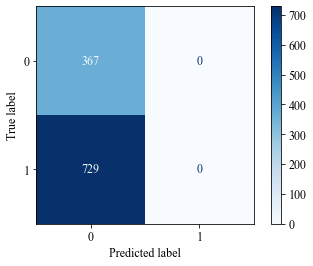

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = ["0", "1"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Graph True vs. Predicted Scatter Plot

source: https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value

/Users/fabianazinna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


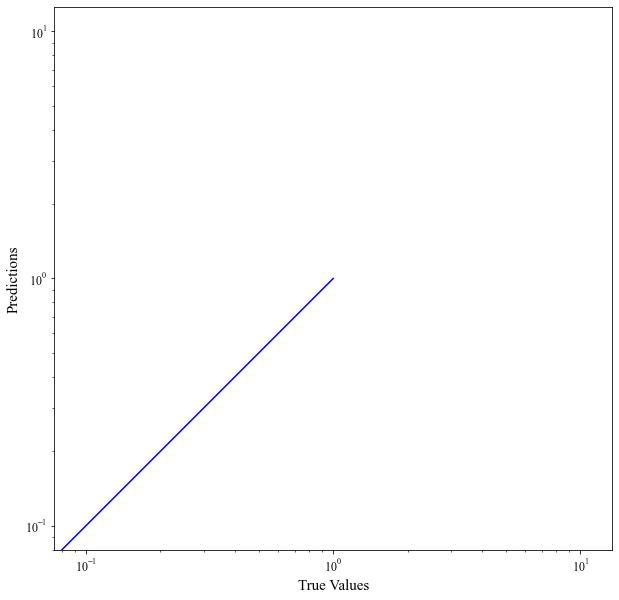

In [22]:
# y_pred & y_true wurde oben bereits definiert bei Confusion Matrix
plt.figure(figsize=(10,10))
plt.scatter(y_true, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Epochen Error Plot

source: https://stackoverflow.com/questions/63038234/how-do-i-plot-steps-per-epoch-against-loss-using-fit-generator-in-keras

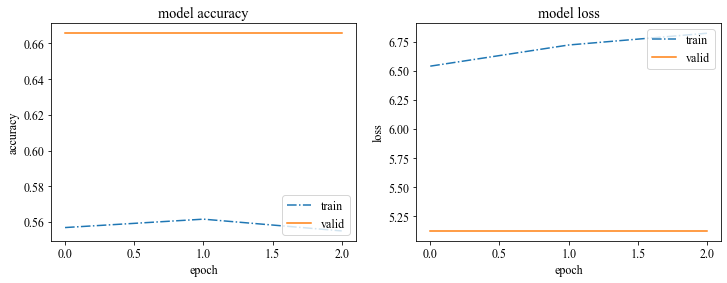

In [23]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Train vs. Validation (colab?)

### True positives / false positives (ROC curve / AUC score)

source: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

definition: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

25/37 [===================>..........] - ETA: 5:08

KeyboardInterrupt: 

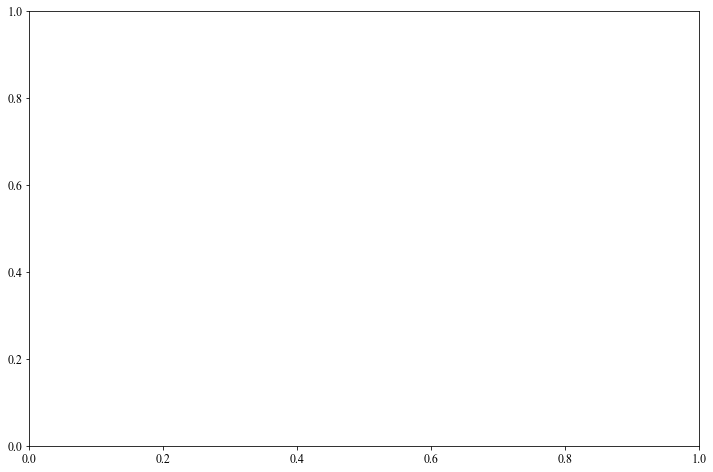

In [21]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(n_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
validation_generator.reset() # resetting generator
y_pred = cnn.predict_generator(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(validation_generator.classes, y_pred)